Esse notebook irá fazer um baseline utilizando redes neurais para computar a probabilidade de um nó ser ocultado baseando-se apenas na expressão da descrição. Os dados de treinamento serão criados expandindo-se apenas um nível da árvore de provas, chamando os novos nós de 1 e os originais 0. Para verificar se os nós são os mesmos, vamos utilizar as expressões apenas, já que uma vez que um nó é expandido a sua proposição original se quebra em diversas proposições que constituem sua prova.

https://www.youtube.com/watch?v=8owQBFAHw7E

https://www.youtube.com/watch?v=uF53xsT7mjc

In [1]:
import sys
sys.path.append("../../src")

import random

from collections import Counter, defaultdict

import json

import glob

import os

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

import pickle
import time

In [2]:
!ls -lhS ../../data/datasets 

total 224
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 14:20 1660238382.459042
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 14:45 1660239915.82247
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 16:01 1660244354.1733959
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 16:21 1660245663.179106
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 16:21 1660245700.0048451
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 16:23 1660245781.935104
drwx------@ 1 lucasvoliveira  staff    16K Aug 11 18:32 1660253531.516595


In [3]:
dataset_name = "1660253531.516595"

train_props = json.load(open(f"../../data/datasets/{dataset_name}/train.json"))
valid_props = json.load(open(f"../../data/datasets/{dataset_name}/valid.json"))
test_props = open(f"../../data/datasets/{dataset_name}/test.txt").read().split("\n")

print(len(train_props))
print(len(valid_props))
print(len(test_props))

24769
1802
22


In [54]:
tem que rever porque os teoremas expandidos nos teoremas de teste podem ter sido usados no treinamento. Talvez seja interessante tirar isso tbm dos dados de teste

SyntaxError: invalid syntax (2979950303.py, line 1)

In [ ]:
checar porque o mp2 nao esta em lugar nenhum

In [65]:
train_props_labels = set([p['prop'] for p in train_props])
valid_props_labels = set([p['prop'] for p in valid_props])

In [68]:
'mp2' in valid_props_labels

False

In [69]:
for p in valid_props[400:500]:
    print(p['prop'], p["steps"][0][2])

eliunxp ( C e. U_ x e. A ( { x } X. B ) <-> E. x E. y ( C = <. x , y >. /\ ( x e. A /\ y e. B ) ) )
eliunxp ( C e. U_ x e. A ( { x } X. B ) <-> E. x E. y ( C = <. x , y >. /\ ( x e. A /\ y e. B ) ) )
eliunxp ( C e. U_ x e. A ( { x } X. B ) <-> E. x E. y ( C = <. x , y >. /\ ( x e. A /\ y e. B ) ) )
rexrnmpt ( A. x e. A B e. V -> ( E. y e. ran F ps <-> E. x e. A ch ) )
raaan ( A. x e. A A. y e. A ( ph /\ ps ) <-> ( A. x e. A ph /\ A. y e. A ps ) )
tpeq123d ( ph -> { A , C , E } = { B , D , F } )
hbabd ( ph -> ( z e. { y | ps } -> A. x z e. { y | ps } ) )
reiota1 ( ( x e. A /\ E! x e. A ph ) -> ( ph <-> ( iota x ( x e. A /\ ph ) ) = x ) )
reiota1 ( ( x e. A /\ E! x e. A ph ) -> ( ph <-> ( iota x ( x e. A /\ ph ) ) = x ) )
reiota1 ( ( x e. A /\ E! x e. A ph ) -> ( ph <-> ( iota x ( x e. A /\ ph ) ) = x ) )
ssiun2 ( x e. A -> B C_ U_ x e. A B )
sbi1 ( [. y / x ]. ( ph -> ps ) -> ( [. y / x ]. ph -> [. y / x ]. ps ) )
sbi1 ( [. y / x ]. ( ph -> ps ) -> ( [. y / x ]. ph -> [. y / x ]. ps ) )

In [51]:
for p in valid_props:
    p
    if p['prop'] == 'mp2':
        print("mp2")
        break

In [4]:
def get_prop_parameters(target_prop):
    steps_dict = {s[0]:{
        "prop": s[1], 
        "statement":s[2], 
        "prop_statement":s[3], 
        "lemma_complexity":max(s[4], 1), #Ensure there is no 0 complexity value
        "y":s[5]
    } for s in target_prop["steps"]}

    #Add neighbors refs
    for s in steps_dict.values():
        s["inputs"] = []
        s["output"] = None
    for s, d in target_prop["links"]:
        steps_dict[d]["inputs"].append(s)
        steps_dict[s]["output"] = d
        
    #Add number of neighbors
    for s in steps_dict.values():   
        s["n_neighbors"] = len(s["inputs"]) + (1 if s["output"] != None else 0)
    
    #Add number of symbols in the statement
    for s in steps_dict.values():
        s["ns"] = len(s["statement"].split(" "))

    #Add number of distinct symbols in the statement
    for s in steps_dict.values():
        s["nds"] = len(set(s["statement"].split(" ")))
        
    #Add ratio between # of symbols and # of distinct symbols
    for s in steps_dict.values():
        s["ns_nds_ratio"] = s["ns"] / s["nds"]
        
    #Add number of symbols in the statement normalize with the largest
    largest_ns = max([s["ns"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["ns_norm"] = s["ns"] / largest_ns

    #Add number of distinct symbols in the statement normalize with the largest
    largest_nds = max([s["nds"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["nds_norm"] = s["nds"] / largest_nds
        
    #Normalize lemma complexities with the largest
    largest_lc = max([s["lemma_complexity"] for s in steps_dict.values()])
    for s in steps_dict.values():
        s["lemma_complexity_norm"] = s["lemma_complexity"] / largest_lc
    
        
    #Add neighbors summarized parameters
    neighbors_params = ["ns", "nds", "ns_norm", "nds_norm", "ns_nds_ratio", "lemma_complexity", "lemma_complexity_norm"]

    for s in steps_dict.values():
        for p in neighbors_params:
            neighbors_values = []
            if s["output"] != None:
                neighbors_values.append(steps_dict[s["output"]][p])
            for inp in s["inputs"]:
                neighbors_values.append(steps_dict[inp][p])

            s[f"neighbor_{p}_max"] = max(neighbors_values)
            s[f"neighbor_{p}_min"] = min(neighbors_values)
            s[f"neighbor_{p}_avg"] = np.mean(neighbors_values)
            
            s[f"neighbor_{p}_max_ratio"] = s[p] / s[f"neighbor_{p}_max"]
            s[f"neighbor_{p}_min_ratio"] = s[p] / s[f"neighbor_{p}_min"]
            s[f"neighbor_{p}_avg_ratio"] = s[p] / s[f"neighbor_{p}_avg"]
            
            
    #Add jaccard similarity between node statement symbols and its neighbors statement symbols
    for s in steps_dict.values():
        jacc_simm_values = []
        ratio_over_unions = []
        ratio_over_intersections = []
        
        neighbors_refs = []
        
        if s["output"] != None:
            neighbors_refs.append(steps_dict[s["output"]])
        
        for inp in s["inputs"]:
            neighbors_refs.append(steps_dict[inp])
            
        s_symbols = set(s["statement"].split(" "))
            
        for n in neighbors_refs:
            n_symbols = set(n["statement"].split(" "))
            
            jacc_val = len(s_symbols.intersection(n_symbols)) / len(s_symbols.union(n_symbols))
            jacc_simm_values.append(jacc_val)
            
            ratio_over_unions.append(len(s_symbols)/len(s_symbols.union(n_symbols)))
            ratio_over_intersections.append(len(s_symbols.intersection(n_symbols))/len(s_symbols))
            
        s["neighbors_jacc_sim_min"] = min(jacc_simm_values)
        s["neighbors_jacc_sim_max"] = max(jacc_simm_values)
        s["neighbors_jacc_sim_avg"] = np.mean(jacc_simm_values)
        
        s["neighbors_ratio_union_min"] = min(ratio_over_unions)
        s["neighbors_ratio_union_max"] = max(ratio_over_unions)
        s["neighbors_ratio_union_avg"] = np.mean(ratio_over_unions)
        
        s["neighbors_ratio_intersection_min"] = min(ratio_over_intersections)
        s["neighbors_ratio_intersection_max"] = max(ratio_over_intersections)
        s["neighbors_ratio_intersection_avg"] = np.mean(ratio_over_intersections)
        
    #Include whether some of its neighbors has been hidden or not
    #This may be helpful while working with the iterative algorithm to determine whether or not some node should be hidden
            
    return steps_dict

In [6]:
all_features = list(list(get_prop_parameters(train_props[0]).values())[0].keys())
features2remove = ["prop", "statement", 'prop_statement', "y", "inputs", "output"]
features2use = sorted([f for f in all_features if f not in features2remove])
#features2use

In [22]:
def get_props_features_xy(p):
    prop_features_x = []
    prop_features_y = []
    features2remove = ["prop", "statement", 'prop_statement', "y", "inputs", "output"]
    
    for s in get_prop_parameters(p).values():
        
        feature_names = sorted(s.keys())#Sort keys is important to ensure feature order

        s_features = []
        for f in feature_names:
            if f not in features2remove:
                s_features.append(s[f])
            
        prop_features_x.append(s_features)
        prop_features_y.append(s["y"])

    return prop_features_x, prop_features_y

In [23]:
len(get_props_features_xy(train_props[0])[1])

126

In [24]:
%%time

train_features_x = []
train_features_y = []

for i, p in enumerate(train_props):
    print(f"\r{i+1}/{len(train_props)}", end="")
    
    features_x, features_y = get_props_features_xy(p)
    train_features_x.extend(features_x)
    train_features_y.extend(features_y)
    
print("\n")

24769/24769

CPU times: user 1min 39s, sys: 3.1 s, total: 1min 42s
Wall time: 1min 47s


In [42]:
##Make checkpoint
#np.save(open("train_x_preproc_1659467564.761641.npy", "wb"), train_features_x, False)
#np.save(open("train_y_preproc_1659467564.761641.npy", "wb"), train_features_y, False)

#train_features_x = np.load(open("train_x_preproc_1659467564.761641.npy", "rb"))
#train_features_y = np.load(open("train_y_preproc_1659467564.761641.npy", "rb"))

In [43]:
#train_features_x = train_features_x[:,1:] #Remove number of neighbors

In [25]:
print(len(train_features_x))
print(len(train_features_y))

923629
923629


In [27]:
sum(train_features_y)/len(train_features_y)

0.9047019961478039

In [28]:
#train_features_x = np.round(train_features_x, 2)

In [29]:
%%time

train_features_xy = []
for tx, ty in zip(train_features_x, train_features_y):
    train_features_xy.append(tuple(tx + [ty]))
    
single_tx, single_ty = [],[]
for txy in set(train_features_xy):
    single_tx.append(txy[:-1])
    single_ty.append(txy[-1])
    
print(len(single_tx))
print(len(single_ty))

print(np.mean(single_ty))

245469
245469
0.7140046197279494
CPU times: user 3.11 s, sys: 3.28 s, total: 6.39 s
Wall time: 17.5 s


In [30]:
#single_tx, single_ty = train_features_x, train_features_y

In [31]:
%%time

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=2,
    random_state=2
)

rf_clf.fit(single_tx, single_ty)

CPU times: user 3min 14s, sys: 2.09 s, total: 3min 16s
Wall time: 1min 41s


RandomForestClassifier(n_estimators=200, n_jobs=2, random_state=2)

In [32]:
rf_clf.score(single_tx, single_ty)

0.97883643148422

In [34]:
valid_features_x = []
valid_features_y = []

for i, p in enumerate(valid_props):
    print(f"\r{i+1}/{len(valid_props)}", end="")
    
    p_features, p_ys = get_props_features_xy(p)
    
    valid_features_x.append(p_features)
    valid_features_y.append(p_ys)

1802/1802

In [33]:
# valid_features_x = []
# valid_features_y = []

# for i, p in enumerate(valid_props):
#     print(f"\r{i+1}/{len(valid_props)}", end="")
    
#     p_features = []
#     p_ys = []
#     for s in get_prop_parameters(p).values():
        
#         s_features = []
#         for f in features2use:
#             s_features.append(s[f])
         
#         p_features.append(s_features)
#         p_ys.append(s["y"])
    
    
#     valid_features_x.append(p_features)
#     valid_features_y.append(p_ys)

1802/1802

In [35]:
#Metrics to check 
metrics2check = {
    "accuracy_score": accuracy_score, 
    "average_precision_score": average_precision_score, 
    "balanced_accuracy_score": balanced_accuracy_score,
    "f1_score": f1_score, 
    "precision_score": precision_score, 
    "recall_score": recall_score, 
    "roc_auc_score": roc_auc_score
}

In [36]:
#Score flatten accuracy

metric_arr = defaultdict(list)

valid_features_x_flatten = []
for d in valid_features_x:
    valid_features_x_flatten.extend(d)
    
valid_features_y_flatten = []
for d in valid_features_y:
    valid_features_y_flatten.extend(d)
    
valid_features_x_flatten = np.round(valid_features_x_flatten,2)
    
print(len(valid_features_x_flatten))
print(len(valid_features_y_flatten))
print()
      
pprob = rf_clf.predict_proba(valid_features_x_flatten)[:,1]
ppred = pprob > 0.5

for m, m_func in metrics2check.items():
    if m == "precision_score":
        m_val = m_func(valid_features_y_flatten, ppred, zero_division=0)
    elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
        m_val = m_func(valid_features_y_flatten, ppred)
    else:
        m_val = m_func(valid_features_y_flatten, pprob)
    metric_arr[m].append(m_val)
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

78181
78181

accuracy_score 0.8031874752177639
average_precision_score 0.9481896020835957
balanced_accuracy_score 0.6331131605422855
f1_score 0.88627914711208
precision_score 0.9406513758589313
recall_score 0.837849167866076
roc_auc_score 0.6719666310879926


In [37]:
metric_arr = defaultdict(list)

for i, (px, py) in enumerate(zip(valid_features_x, valid_features_y)):
    print(f"\r{i+1}/{len(valid_features_x)}", end="")
    
    #px = np.round(px,2)
    
    pprob = rf_clf.predict_proba(px)[:,1]
    #pprob = np.array([1-_x[4] for _x in px]) #ONly number of symbols normalized
    ppred = pprob > 0.5
    
    for m, m_func in metrics2check.items():
        if m == "precision_score":
            m_val = m_func(py, ppred, zero_division=0)
        elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
            m_val = m_func(py, ppred)
        else:
            m_val = m_func(py, pprob)
    
        metric_arr[m].append(m_val)
        
print("\n")
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

1802/1802

accuracy_score 0.8200042934284597
average_precision_score 0.9432229821723455
balanced_accuracy_score 0.6999731398217022
f1_score 0.8832551759444873
precision_score 0.8986645308026147
recall_score 0.8958247260560865
roc_auc_score 0.7848257608563465


<BarContainer object of 59 artists>

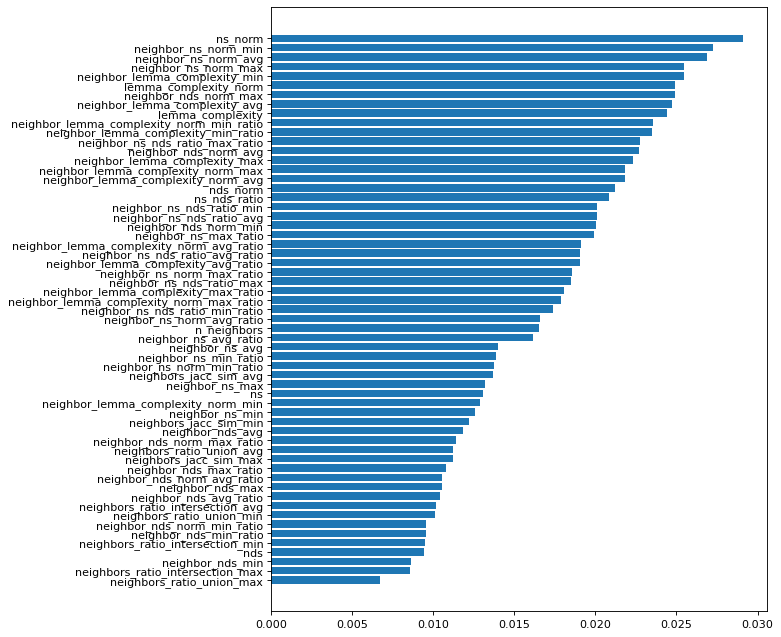

In [38]:
plt.figure(figsize=(8, 10), dpi=80)

plt.barh(np.array(features2use)[rf_clf.feature_importances_.argsort()], 
    rf_clf.feature_importances_[rf_clf.feature_importances_.argsort()])

- keep working on the machine learning baseline

- maybe include other metrics like complexity of the nodes, etc

- verify if order matters of the features - No as expected, it doesnt

- test this with more complex expansions (like random expansions)

In [44]:
ts = time.time()

#workdir = "/Users/lucasvoliveira/Desktop"
workdir = "../../data"

In [45]:
os.mkdir(os.path.join(workdir, "trained_models", str(ts)))

In [46]:
pickle.dump(rf_clf, open(os.path.join(workdir, "trained_models", str(ts), "model.pkl"), "wb"))

In [34]:
metric_arr = defaultdict(list)

test_label_123 = test_props[7]
print(test_label_123)

tgt_feat_x, tgt_feat_y = get_props_features_xy(props_dict[test_label_123])

tgt_feat_x = np.round(tgt_feat_x,2)

tgt_prob = rf_clf.predict_proba(tgt_feat_x)[:,1]
tgt_pred = tgt_prob > 0.5

for m, m_func in metrics2check.items():
    try:
        if m == "precision_score":
            m_val = m_func(tgt_feat_y, tgt_pred, zero_division=0)
        elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
            m_val = m_func(tgt_feat_y, tgt_pred)
        else:
            m_val = m_func(tgt_feat_y, tgt_prob)
    except Exception as e:
        print(m, m_func)
        raise e

    metric_arr[m].append(m_val)
    
metric_arr

t5lucas


NameError: name 'props_dict' is not defined

In [26]:
print(test_label_123)
print()

for s, _pred, _prob in zip(props_dict[test_label_123]["steps"], tgt_pred, tgt_prob):
    print(s[0], s[1], "\t\t", s[4], "\t", _pred, _prob)

t5lucas

1 mp2 		 1 	 True 0.9
2 sylanbrc 		 1 	 True 0.6
3 ax-mp 		 1 	 True 0.8
4 ax-mp 		 1 	 True 1.0
5 ax-gen 		 1 	 False 0.0
6 syl 		 1 	 True 0.7
7 ax-mp 		 1 	 True 0.7
8 pm5.21nii 		 1 	 True 1.0
9 elex 		 0 	 False 0.0
10 adantl 		 0 	 False 0.0
11 elex 		 0 	 False 0.0
12 elab2g 		 0 	 False 0.0
13 anbi12d 		 0 	 False 0.0
14 eleq1 		 0 	 False 0.0
15 eleq1 		 0 	 False 0.0
16 df-in 		 0 	 False 0.0
17 bi1 		 0 	 False 0.0
18 simpl 		 0 	 False 0.0
19 biimpi 		 1 	 False 0.1
20 bicomi 		 0 	 True 0.8
21 bitr4i 		 1 	 True 0.9
22 3bitri 		 0 	 False 0.1
23 dfss 		 0 	 False 0.1
24 eqeq2i 		 0 	 False 0.0
25 df-in 		 0 	 False 0.0
26 abeq2 		 0 	 False 0.0
27 albii 		 0 	 False 0.0
28 pm4.71 		 0 	 False 0.0
29 ax-1 		 0 	 False 0.0
30 syl 		 1 	 True 0.9
31 alrimi 		 1 	 False 0.1
32 ax-17 		 0 	 True 0.7
33 syl6 		 1 	 True 0.9
34 mpd 		 1 	 True 0.6
35 syl5com 		 1 	 True 0.9
36 id 		 0 	 False 0.0
37 syl5com 		 1 	 False 0.3
38 id 		 0 	 False 0.0
39 3imtr4g 		 1 	 True 1

In [27]:
statement_probs = []

for s, pr, gt in zip(tgt_prop["steps"], tgt_pred, tgt_feat_y):
    if gt == 1:
        statement_probs.append((s[2], pr[1]))

statement_probs

NameError: name 'tgt_prop' is not defined

In [ ]:
sorted(statement_probs, key=lambda a: a[1])

talvez seja interessante comentar que partir de algo sumarizado para algo mais detalhado eh mais facil apra o estudante do que o contrario do ponto de vista de compreensao ja que para sumarizar para entender melhor o estudante em tese teria ja que ter um dominio do assunto.

preciso verificar porque provavelmente os labels estao vazando por meio da feature number of neighbors because the way we are expnading nodes. Expanding only the first depth will is likely to create a bipartite graph. The proper way to do this is to expand randomly.

Another thing is that the way we are working we cannot detect when we are supposed to have one step in between. This is not a big problem because our proposal here is to summarize (reduce size of presentation) of a proof. But nevertheless, it may also be a good idea to work by hidding steps to help our model generalize better and possible "learn" how to classify such things.